## 5.
1.Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.


2.Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import re

import scipy
from tqdm import tqdm

import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
# utility functions
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [5]:
col_names1 = ['id','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq',
              'abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio',
              'longest_substr_ratio','freq_qid1', 'freq_qid2', 'q1len', 'q2len','q1_n_words', 'q2_n_words',
              'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2']

data = pd.read_csv('final_features.csv',usecols=col_names1)

In [6]:
print("No of data points ",data.shape[0])
print("Dimension",data.shape[1])
data.head()

No of data points  404290
Dimension 27


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [7]:
train_df1 = pd.read_csv("train.csv",usecols= ['id','question1','question2','is_duplicate'])
 
train_df1['question1'] = train_df1['question1'].apply(lambda x: str(x))
train_df1['question2'] =train_df1['question2'].apply(lambda x: str(x))

In [8]:
print(train_df1.shape)
train_df1.head()

(404290, 4)


,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
#inner: use intersection of keys from both frames, similar to a SQL inner
train_df1 = train_df1.merge(data, on='id',how='inner')
train_df1.head()

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
#Dimension of data after merging

In [10]:
print("No of data points ",train_df1.shape[0])
print("Dimension",train_df1.shape[1])

No of data points  404290
Dimension 30


# 5.2 Exploratory Data Analysis

In [11]:
train_df1.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

# 5.2.1 Distribution of data points among output classes

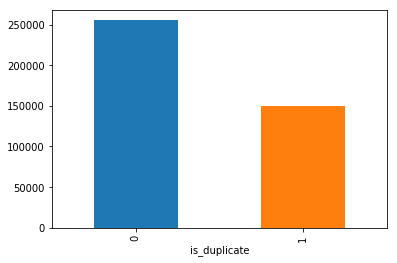

In [12]:
#Distribution of data points among output classes
train_df1.groupby("is_duplicate")['id'].count().plot.bar()

In [13]:
print('~> Total number of question pairs for training:\n   {}'.format(len(train_df1)))

~> Total number of question pairs for training:
   404290


In [14]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(train_df1['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(train_df1['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


# 5.2.2 Words occurance in Question 1 and Question 2

In [15]:
print ("Minimum length of the questions in question1 : " , min(train_df1['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(train_df1['q2_n_words']))
 
print ("Number of Questions with minimum length [question1] :", train_df1[train_df1['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train_df1[train_df1['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


## 5.2.2.1 Number of words in Question 1 

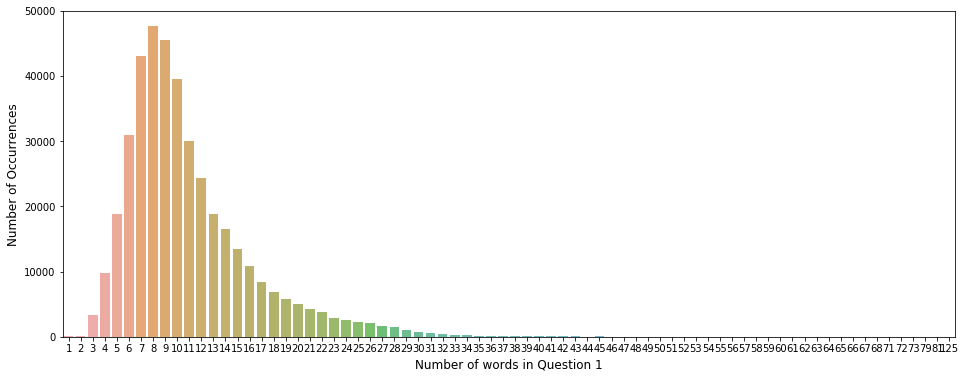

In [16]:
count = train_df1['q1_n_words'].value_counts()
plt.figure(figsize=(16,6))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in Question 1', fontsize=12)
plt.show()

In [17]:
print("Max no of occurance of words in question 1 = ",count.argmax(),"in no of questions",count.max())

Max no of occurance of words in question 1 =  8 in no of questions 47606


##### Observation:
1.Above plot is the count of the what no of words occurs in the what no of questions

2.Max no of words in question 1 = 8 in no of questions 47606

## 5.2.2.2 Number of words in Question 2 

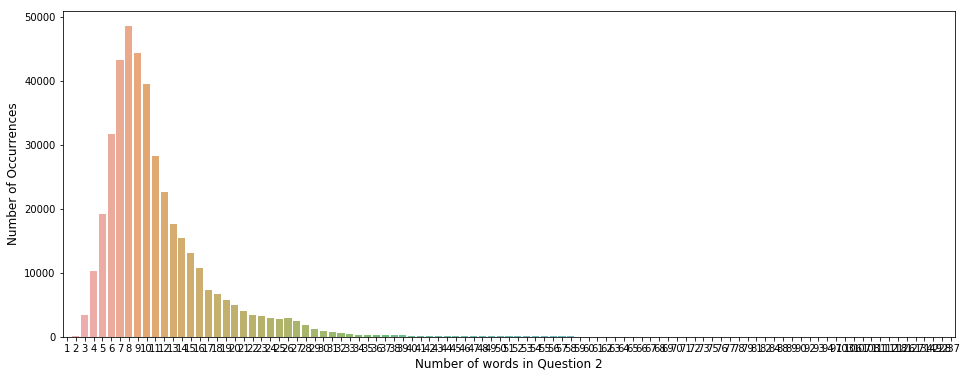

In [18]:
count = train_df1['q2_n_words'].value_counts()

plt.figure(figsize=(16,6))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in Question 2', fontsize=12)
plt.show()

In [19]:
print("Max no of occurance of words in question 2 = ",count.argmax(),"in no of questions",count.max())

Max no of occurance of words in question 2 =  8 in no of questions 48558


##### Observation:
1.Above plot is the count of the what no of words occurs in the what no of questions

2.Max no of words in question 2 = 8 in no of questions 48558

# 5.2.3 Frequency of Question

# 5.2.3.1 Frequency of Question 1

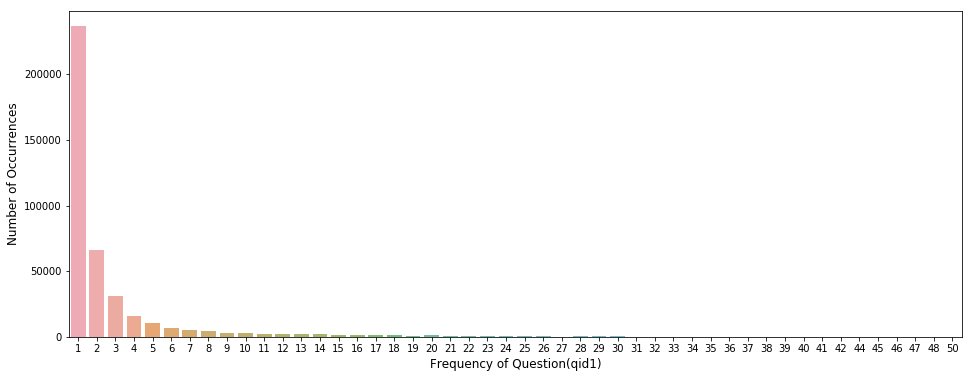

In [20]:
# Frequency of Question 1
count = train_df1['freq_qid1'].value_counts()
plt.figure(figsize=(16,6))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Frequency of Question(qid1)', fontsize=12)
plt.show()

##### Observations:
From above plot we can see that max questions occurs only one's in question 2

## 5.2.3.2 Frequency of Question 2 

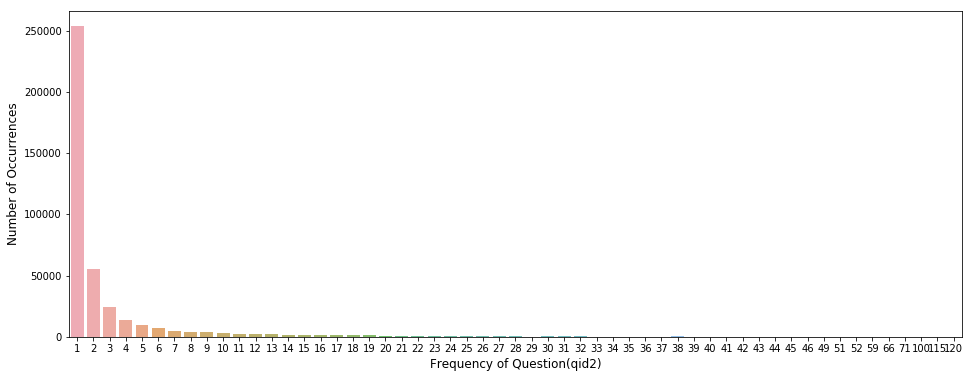

In [21]:
# Frequency of Question 2
count = train_df1['freq_qid2'].value_counts()
plt.figure(figsize=(16,6))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Frequency of Question(qid2)', fontsize=12)
plt.show()

##### Observations:
From above plot we can see that max questions occurs only one's in question 2

# 5.2.4 word_Common

.(Number of common unique words in Question 1 and Question 2)

.As we know more the common words in question 1 and question 2 heigher the chance of they are duplicates of one another

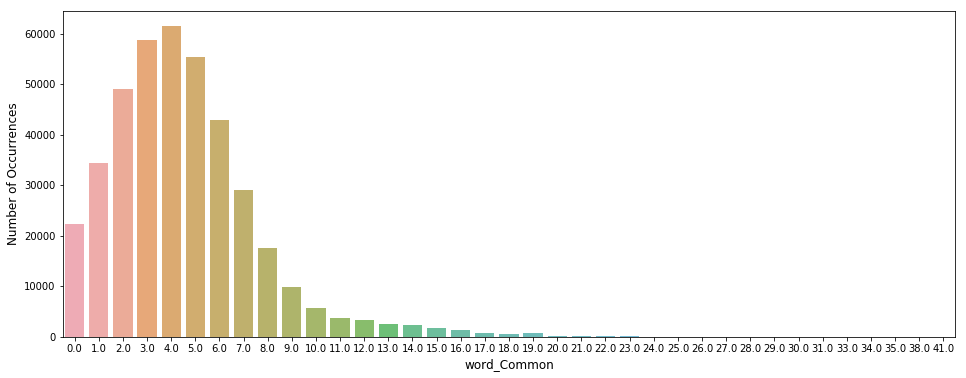

In [22]:
count = train_df1['word_Common'].value_counts()

plt.figure(figsize=(16,6))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('word_Common', fontsize=12)
plt.show()

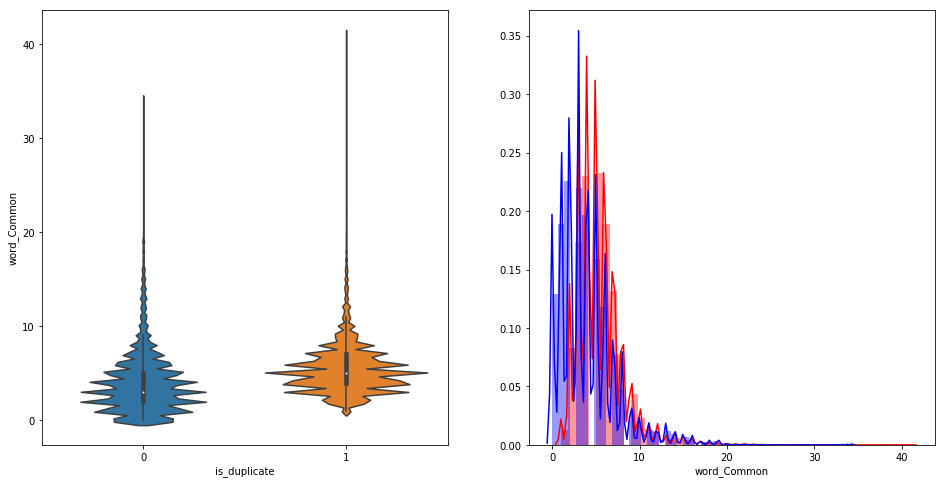

In [23]:

df = train_df1
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

##### Observations :
The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

# 5.2.5 word_share


.word_Common = (Number of common unique words in Question 1 and Question 2)

.word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

.word_share = (word_common)/(word_Total)

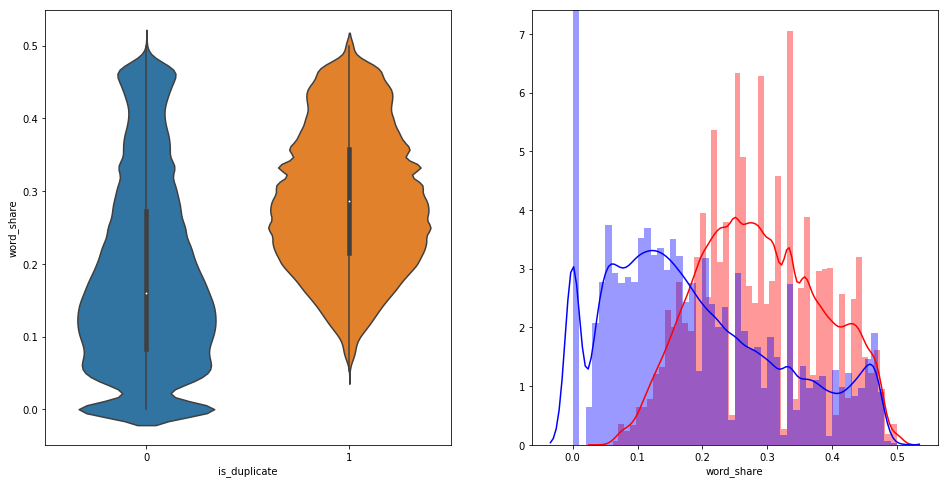

In [24]:
df = train_df1
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

##### Observations
The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity

The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

# 5.2.6 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

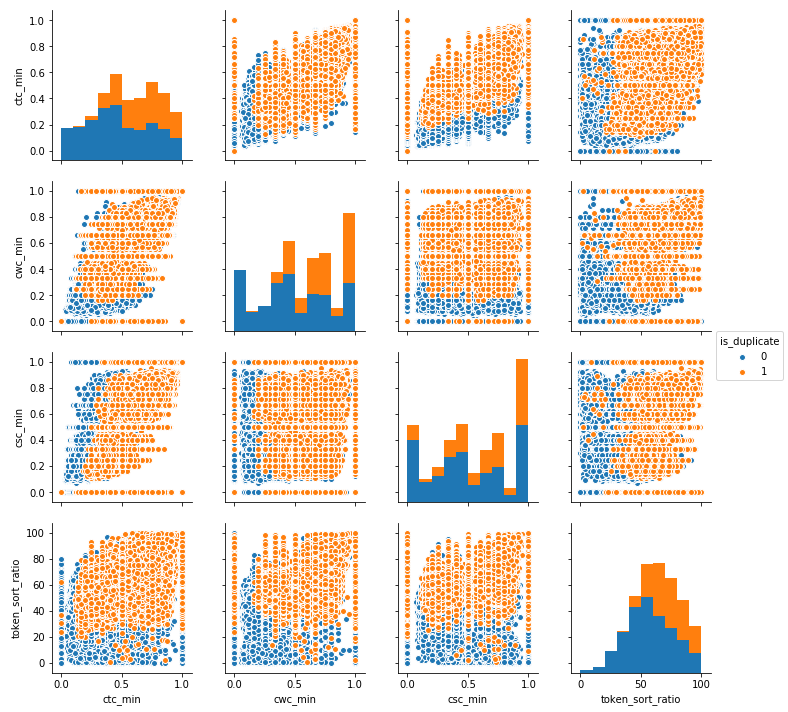

In [25]:
n = train_df1.shape[0]
sns.pairplot(train_df1[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

# 5.2.7 fuzz_ratio

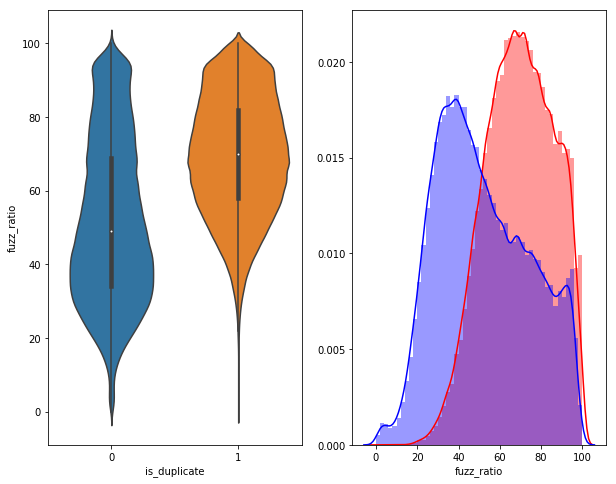

In [26]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

##### Observations :
1.From the above distributions we can see that both the classes are most likely overlapping each other and as we know
fuzz_ratio has some plm like having with inconsisten strings eg("chennai super kings","super kings") as we can see the eg both are the same name of team but fuzz ration treates it as low similar. and to over come this plm we have fuzz_partial_ratio lets look at fuzz_partial_ratio

# 5.2.8 fuzz_partial_ratio

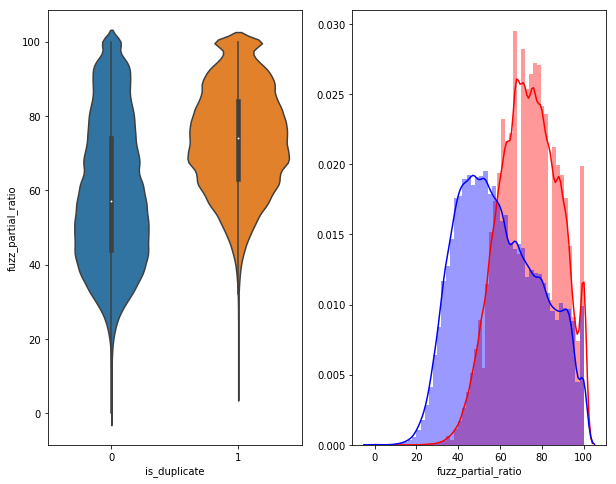

In [27]:

# Distribution of the fuzz_partial_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

###### Observations :
In above plot we can se this is also most likely overlapped class which is similar to above what we are getting in fuzz_ratio

# 5.3 Data Sampling

In [28]:
sample_df = train_df1.sample(n=100000,random_state = 42)
sample_df.shape

(100000, 30)

In [29]:
# getting class lables from the data fram 
y_true = sample_df['is_duplicate']
y_true.shape[0]

100000

## 5.3.1 Random train test split( 70:30)

In [30]:
X_train,X_test, y_train, y_test = train_test_split(sample_df, y_true, stratify=y_true, test_size=0.3)

In [31]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 30)
Number of data points in test data : (30000, 30)


In [32]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6287857142857143 Class 1:  0.3712142857142857
---------- Distribution of output variable in train data ----------
Class 0:  0.3712 Class 1:  0.3712


# 5.3.2 Featurizing text data with tfidf

In [33]:
# converting our test and train data questions 1 into tfidf vec
tfidf_vectorizer1 = TfidfVectorizer(lowercase=False,max_features= 20000)
train_qs1_tfidf = tfidf_vectorizer1.fit_transform(X_train['question1'])
test_qs1_tfidf  = tfidf_vectorizer1.transform(X_test['question1'])

In [34]:
print(train_qs1_tfidf.shape)
print(test_qs1_tfidf.shape)

(70000, 20000)
(30000, 20000)


In [35]:
tfidf_vectorizer2 = TfidfVectorizer(lowercase=False,max_features= 20000)
train_qs2_tfidf = tfidf_vectorizer2.fit_transform(X_train['question2'])
test_qs2_tfidf  = tfidf_vectorizer2.transform(X_test['question2'])


In [36]:
print(train_qs2_tfidf.shape)
print(test_qs2_tfidf.shape)

(70000, 20000)
(30000, 20000)


Merging both q1 and q2 tfidf vect in one data frame

In [37]:
# tfidf q1 train + tfidf q2 train
tfidf_train = hstack((train_qs1_tfidf,train_qs2_tfidf))
# tfidf q1 test + tfidf q2 test
tfidf_test = hstack((test_qs1_tfidf,test_qs2_tfidf))
# after combining both 
print("train data shape",tfidf_train.shape)
print("Test data shape ",tfidf_test.shape)

train data shape (70000, 40000)
Test data shape  (30000, 40000)


In [38]:
# extraction 26 featurese from train and test data frame 
train_feature_df = X_train.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)
test_feature_df = X_test.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)

In [39]:
# X_train.head()
print("train Shape -> ",train_feature_df.shape," Type",type(train_feature_df))
print("test shape -> ",test_feature_df.shape, " Type", type(test_feature_df))

train Shape ->  (70000, 26)  Type <class 'pandas.core.frame.DataFrame'>
test shape ->  (30000, 26)  Type <class 'pandas.core.frame.DataFrame'>


In [40]:
#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
train_feat_sparse = scipy.sparse.csr_matrix(train_feature_df)
test_feat_sparse = scipy.sparse.csr_matrix(test_feature_df)

print("train Shape -> ",train_feat_sparse.shape," Type",type(train_feat_sparse))
print("test shape -> ",test_feat_sparse.shape, " Type", type(test_feat_sparse))

train Shape ->  (70000, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>
test shape ->  (30000, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [41]:
# combining our tfidf and features into one 
# train features(feat + tfidfvec(q1 + q2))

tfidf_X_train = hstack((train_feat_sparse,tfidf_train))
# test features(feat + tfidfvec)
tfidf_X_test = hstack((test_feat_sparse,tfidf_test))

#final train and test data shape 
# train features(26 + 4000 i.e (2000+2000)) = 40026
print("train data shape",tfidf_X_train.shape)
# test features(26 + 4000 i.e (2000+2000)) = 40026
print("Test data shape ",tfidf_X_test.shape)

train data shape (70000, 40026)
Test data shape  (30000, 40026)


In [42]:
# from sklearn.externals import joblib
# # data points with 0.5 million data 
# joblib.dump(tfidf_X_train, 'tfidf_X_train.pkl') 
# joblib.dump(tfidf_X_test, 'tfidf_X_test.pkl')

# # target class i.e multilabel classes with 0.5 million 
# joblib.dump(y_train, 'y_train.pkl')
# joblib.dump(y_test, 'y_test.pkl')

# tfidf_X_train = joblib.load('tfidf_X_train.pkl')
# tfidf_X_test = joblib.load('tfidf_X_test.pkl')
# y_train = joblib.load('y_train.pkl')
# y_test = joblib.load('y_test.pkl')

# train features(26 + 4000 i.e (2000+2000)) = 40026
print("train data shape",tfidf_X_train.shape)
# test features(26 + 4000 i.e (2000+2000)) = 40026
print("Test data shape ",tfidf_X_test.shape)

train data shape (70000, 40026)
Test data shape  (30000, 40026)


In [43]:
X_train = tfidf_X_train
X_test = tfidf_X_test

# 5.4 Models

## 5.4.1 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8914061664074696


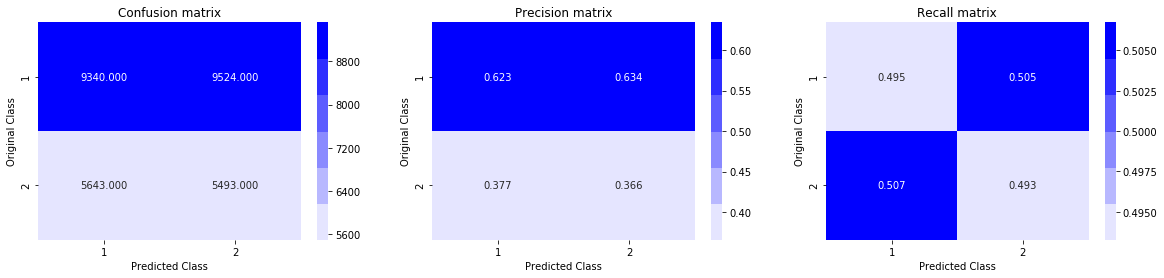

In [44]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 5.4.2 Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4583275281292254
For values of alpha =  0.0001 The log loss is: 0.4573220413812126
For values of alpha =  0.001 The log loss is: 0.448393867375786
For values of alpha =  0.01 The log loss is: 0.4525711135581612
For values of alpha =  0.1 The log loss is: 0.45683934807817134
For values of alpha =  1 The log loss is: 0.4870981460280188
For values of alpha =  10 The log loss is: 0.5391726793461592


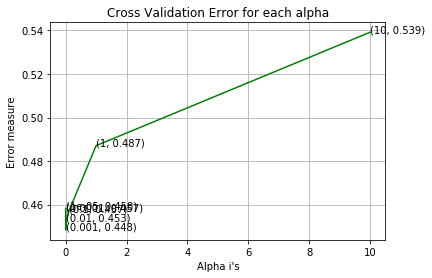

For values of best alpha =  0.001 The train log loss is: 0.45022148808313095
For values of best alpha =  0.001 The test log loss is: 0.448393867375786
Total number of data points : 30000


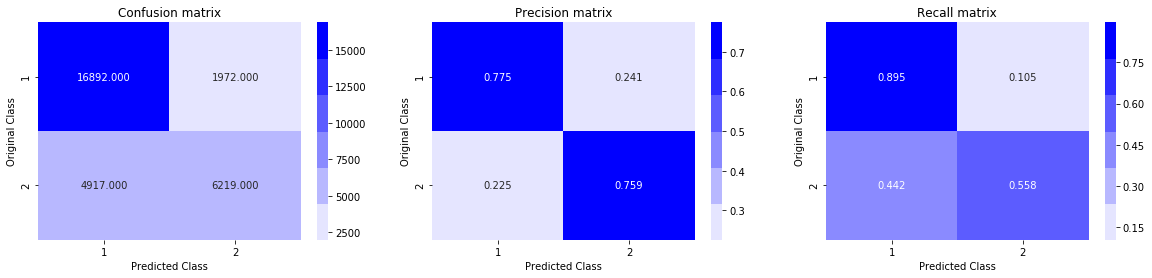

In [45]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5.4.3 Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.46466381414125396
For values of alpha =  0.0001 The log loss is: 0.47837007397898385
For values of alpha =  0.001 The log loss is: 0.4922630016492834
For values of alpha =  0.01 The log loss is: 0.5044813414646993
For values of alpha =  0.1 The log loss is: 0.49939977983163636
For values of alpha =  1 The log loss is: 0.5722586710580424
For values of alpha =  10 The log loss is: 0.651794903255636


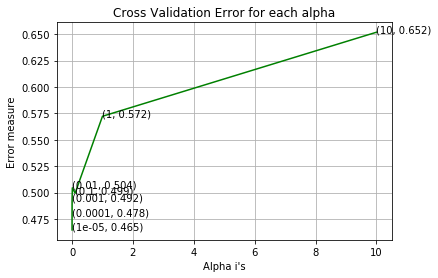

For values of best alpha =  1e-05 The train log loss is: 0.4663194666673005
For values of best alpha =  1e-05 The test log loss is: 0.46466381414125396
Total number of data points : 30000


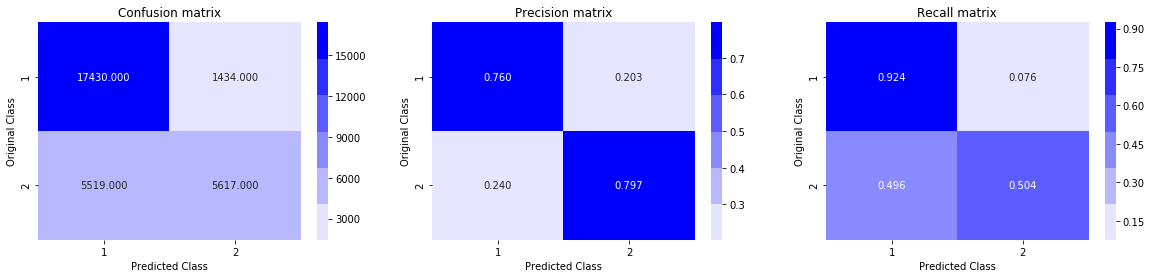

In [46]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5.4.4 XGBoost with hyperparameter tuning

In [47]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'max_depth': [i for i in range(1,8,2)],
        'n_estimators' : [i*10 for i in range(1, 10)],
        'gamma': [0, 0.25, 0.5, 1.0]
        }
x_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_random_search = RandomizedSearchCV(x_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3], 'max_depth': [1, 3, 5, 7], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'gamma': [0, 0.25, 0.5, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [48]:

print("Score : ",xgb_random_search.best_score_)
print("Best Params",xgb_random_search.best_params_)

Score :  -0.3486634550556636
Best Params {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 1.0}


# 5.4.4.1 XGBoost with best hyperparameter

Log loss for tfidf train data :  0.3162808049074414
Log loss for tfidf test data :  0.3475122690310269


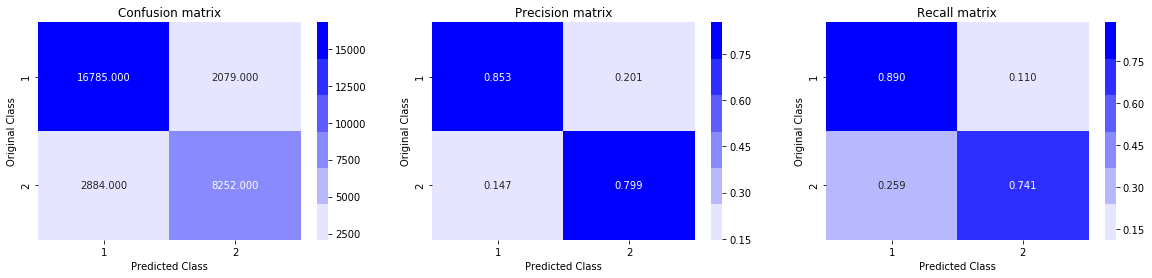

In [49]:
clf = xgb.XGBClassifier(max_depth=5,learning_rate=0.2,objective='binary:logistic',gamma=0.25,n_estimators=90,n_jobs=-1)
clf.fit(X_train, y_train)   

#log loss uses a exact prob score 
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

predict_y = cal_clf.predict_proba(X_train)

print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)

print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

* According to our ploblem statment we have to Identify which questions asked on Quora are duplicates of questions that have already been asked. so thatThis could be useful to instantly provide answers to questions that have already been answered.here We are tasked with predicting whether a pair of questions are duplicates or not.


>> lets start -->


1.As we know we have data set which contains Number of rows 404,290, which contains 5 columns : qid1, qid2, question1, question2, is_duplicate from which 'is_duplicate' is a class lable which specify that the question 1 and question 2 is similar or not and this is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

2.So lets starts with our train and test data set which is in ratio of 80:20.

3.After spliting data into train and test lets start with simple EDA on our dataset, in which we will look at what is the distribution of our data based on class lables and what no of uniques question present and lots more.

4.Now after doing simple EDA on dataset we will try some Basic Feature Extraction (before cleaning) the datset like Frequency of qid1's ,word_Common and etc. and using this featured datset we will do some EDA on it so that we will able to rectify which features are most useful features our of all features i.e(wich feature is helpful for classification)

5.After doing basic Basic feature extractions we will try some Advanced Feature Extraction using NLP and Fuzzy Features but before doing this we will do Preprocessing of Text and then we will do Advanced Feature Extraction and try to visualise our Advanced Feature using EDA, PCA and word clouds.

6.Now as we know we have columns of two questions i.e question 1 and question 2 and we will vectorize that both col using tfidf weighted word-vectors so that we will able to apply models on it and after doing all these we will merge all the features i.e besic features + advance features + question1 tfidf w2v + and question 2 tfidf w2v. and Now after doing all of there we will apply models on it.

7.Here as we know here we are using two main performance matrix in this case study i.e log-loss and confusion matrix and using there we will get our performsnce of the models

8.Lets start: here we are there model i.e Logistic Regression linear svm and XgBoost and a random model which Finding worst-case log-loss and then we try to comparse all

9.In next step we will try our models with other vectorizer i.e tfidf instead of tfidf weighted w2v and try to do some hyperparameter tuning in order to improve the model performance.

# Final Results

In [50]:
from prettytable import PrettyTable
print("TF-IDF w2v")
x = PrettyTable()
x.field_names = ["Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF w2v', 0.5138, 0.5200])
x.add_row(["Linear SVM", 'TF-IDF w2v', 0.4780, 0.4896])
x.add_row(["XGBoost", 'TF-IDF w2v', 0.3455, 0.3570])
print(x)


print("\nUsing Tuned hyperparameter and TF-IDF vec")
x = PrettyTable()
x.field_names = ["Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF ', 0.4601,0.4684])
x.add_row(["Linear SVM", 'TF-IDF ', 0.4738, 0.4836])
x.add_row(["XGBoost", 'TF-IDF ', 0.3175, 0.3525])
print(x)

TF-IDF w2v
+---------------------+------------+----------------+---------------+
|        Model        | Vectorizer | Train log loss | Test log loss |
+---------------------+------------+----------------+---------------+
| Logistic Regression | TF-IDF w2v |     0.5138     |      0.52     |
|      Linear SVM     | TF-IDF w2v |     0.478      |     0.4896    |
|       XGBoost       | TF-IDF w2v |     0.3455     |     0.357     |
+---------------------+------------+----------------+---------------+

Using Tuned hyperparameter and TF-IDF vec
+---------------------+------------+----------------+---------------+
|        Model        | Vectorizer | Train log loss | Test log loss |
+---------------------+------------+----------------+---------------+
| Logistic Regression |  TF-IDF    |     0.4601     |     0.4684    |
|      Linear SVM     |  TF-IDF    |     0.4738     |     0.4836    |
|       XGBoost       |  TF-IDF    |     0.3175     |     0.3525    |
+---------------------+------------+